Чтобы сдать задание, выполните следующую последовательность действий.

1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. **Не используйте данные за последний имеющийся месяц — июнь 2016!** Создайте регрессионные признаки для учёта сезонностей и трендов.
2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.
3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.
4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров $p, q, P, Q$. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.
5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов $K$ или поменять порядки дифференцирования.
6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.
7. Загрузите ноутбук в форму.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings

1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. **Не используйте данные за последний имеющийся месяц — июнь 2016!** Создайте регрессионные признаки для учёта сезонностей и трендов.

In [3]:
current_region = '1282'

In [4]:
from os import listdir
from os.path import isfile, join
import re

files = [f for f in listdir('.') if isfile(join('.', f)) and f.startswith('time_region')]

data = []

for file in files:
    date = re.split('_|\.', file)[-2]
    if date == '2016-06':
        continue
    time_reg = pd.read_csv('time_region_' + date + '.csv', index_col='tpep_pickup_datetime')
    data.append(time_reg[[current_region]])

data = pd.concat(data)

In [5]:
data

,1282
tpep_pickup_datetime,
2015-05-01 00:00:00,851
2015-05-01 01:00:00,494
2015-05-01 02:00:00,361
2015-05-01 03:00:00,225
2015-05-01 04:00:00,120
...,...
2016-05-31 19:00:00,1909
2016-05-31 20:00:00,1694
2016-05-31 21:00:00,1492


Переберем все K от 40 до 250 и затем выберем самый лучший

In [6]:
mse_list = []
N = 40 
K = 250
row = np.arange(1, data.shape[0]+1)

for number in range(N, K+1):
    s_c_data = data.copy()
    for i in range(1, number+1):
        s_c_data['s_0'] = row
        s_c_data['s_year_'+str(i)] = np.sin(row*2*np.pi*i/8766)
        s_c_data['c_year_'+str(i)] = np.cos(row*2*np.pi*i/8766)
        s_c_data['s_week_'+str(i)] = np.sin(row*2*np.pi*i/168)
        s_c_data['c_week_'+str(i)] = np.cos(row*2*np.pi*i/168)
    y = data
    X = s_c_data.loc[:, 's_0':]
    model = LinearRegression()
    res = model.fit(X, y)
    mse_list.append(mean_squared_error(data, res.predict(X)))
K_opt = np.argmin(mse_list)

# data['1231cf'] = res.predict(X)

In [8]:
X

,s_0,s_year_1,c_year_1,s_week_1,c_week_1,s_year_2,c_year_2,s_week_2,c_week_2,s_year_3,...,s_week_248,c_week_248,s_year_249,c_year_249,s_week_249,c_week_249,s_year_250,c_year_250,s_week_250,c_week_250
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00,1,0.000717,1.000000,0.037391,0.999301,0.001434,0.999999,0.074730,0.997204,0.002150,...,0.149042,-0.988831,0.177529,0.984116,0.111964,-0.993712,0.178234,0.983988,0.074730,-0.997204
2015-05-01 01:00:00,2,0.001434,0.999999,0.074730,0.997204,0.002867,0.999996,0.149042,0.988831,0.004301,...,-0.294755,0.955573,0.349418,0.936967,-0.222521,0.974928,0.350761,0.936465,-0.149042,0.988831
2015-05-01 02:00:00,3,0.002150,0.999998,0.111964,0.993712,0.004301,0.999991,0.222521,0.974928,0.006451,...,0.433884,-0.900969,0.510207,0.860052,0.330279,-0.943883,0.512055,0.858953,0.222521,-0.974928
2015-05-01 03:00:00,4,0.002867,0.999996,0.149042,0.988831,0.005734,0.999984,0.294755,0.955573,0.008601,...,-0.563320,0.826239,0.654787,0.755814,-0.433884,0.900969,0.656951,0.753933,-0.294755,0.955573
2015-05-01 04:00:00,5,0.003584,0.999994,0.185912,0.982566,0.007168,0.999974,0.365341,0.930874,0.010751,...,0.680173,-0.733052,0.778565,0.627564,0.532032,-0.846724,0.780809,0.624770,0.365341,-0.930874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,9524,0.516972,0.856002,-0.930874,-0.365341,0.885059,0.465480,0.680173,-0.733052,0.998252,...,0.997204,0.074730,-0.194431,-0.980916,-0.433884,0.900969,-0.673540,-0.739151,-0.680173,-0.733052
2016-05-31 20:00:00,9525,0.517586,0.855631,-0.943883,-0.330279,0.885725,0.464210,0.623490,-0.781831,0.998123,...,-0.974928,-0.222521,-0.365484,-0.930818,0.532032,-0.846724,-0.794497,-0.607268,0.623490,0.781831
2016-05-31 21:00:00,9526,0.518199,0.855260,-0.955573,-0.294755,0.886389,0.462940,0.563320,-0.826239,0.997989,...,0.930874,0.365341,-0.524926,-0.851148,-0.623490,0.781831,-0.890012,-0.455937,-0.563320,-0.826239


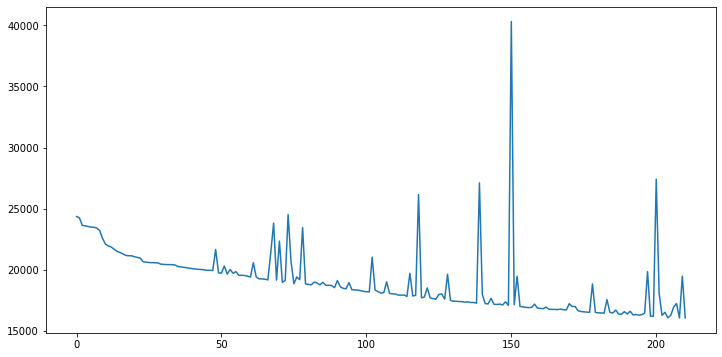

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(mse_list)
plt.show()

In [8]:
K_opt

208

Построим линейную модель с оптимимальным количеством признаков

In [9]:
model = LinearRegression()
model.fit(X.loc[:, :'c_week_208'], data[current_region])
y_pred = model.predict(X.loc[:, :'c_week_208'])
mean_squared_error(data[current_region], y_pred)

16720.84629811929

2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

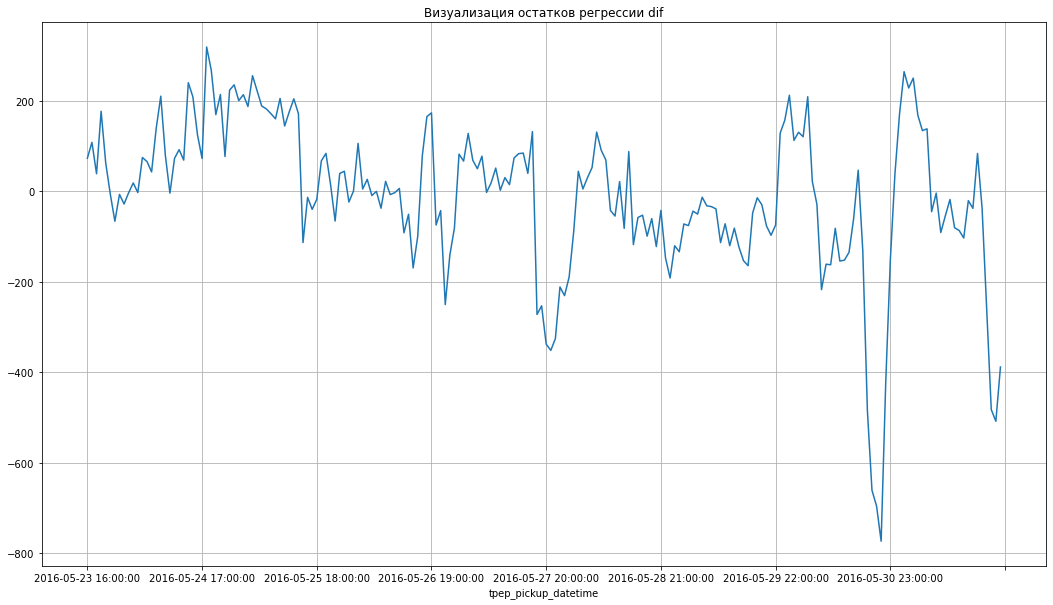

In [10]:
(data[current_region]-y_pred).tail(200).plot(figsize=(18,10))
plt.title('Визуализация остатков регрессии dif')
plt.grid(True)

plt.show()

3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

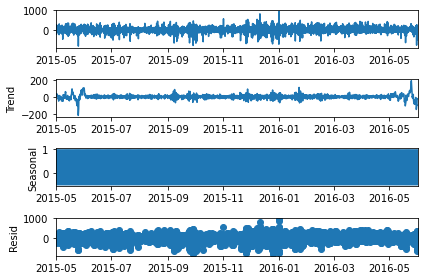

Критерий Дики-Фуллера: p=0.000000


In [11]:
compar = pd.DataFrame(data[current_region]-y_pred)
compar.index = pd.to_datetime(compar.index)
# compar = compar['2016-05-01' :]

# ax = plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(compar, period=24).plot()
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(compar)[1])

4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров $p, q, P, Q$. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

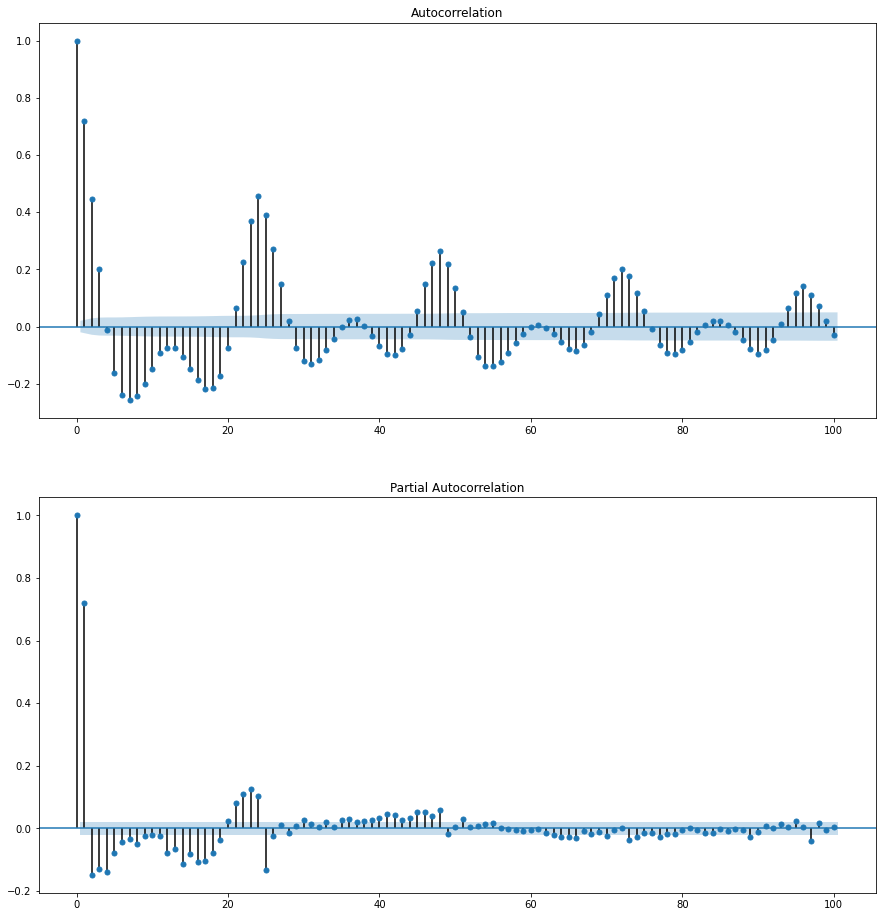

In [12]:
plt.figure(figsize=(15,16))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(compar[24:], lags=100, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(compar[24:], lags=100, ax=ax)
plt.show()

Глядя на наши графики, Выбираем начальные приближения: Q=1, q=4, P=6, p=1   
(в том числе и исходя из разумной достаточности и ограничений вычислительных ресурсов)

In [13]:
ps = range(0, 2)
d=0
qs = range(0, 5)
Ps = range(0, 7)
D=1
Qs = range(0, 2)

In [14]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

140

In [15]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(compar,  order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1, maxiter=10)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print ('parameters:{} have aic value {}'.format(param, aic))
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')
# exog=reg_all решил не использовать, система виснет из-за ограниченности системных ресурсов. 
# Да и сами регрессоры уже учтены в предикторах, на основе ктр и анализируем остатки 

parameters:(0, 0, 0, 0) have aic value 120102.29607129742
parameters:(0, 0, 0, 1) have aic value 117762.2453778126
parameters:(0, 0, 1, 0) have aic value 119050.00660481292
parameters:(0, 0, 1, 1) have aic value 117210.22736788023
parameters:(0, 0, 2, 0) have aic value 118454.77175489077


KeyboardInterrupt: 

5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов $K$ или поменять порядки дифференцирования.

In [112]:
best_params = (1, 0, 1, 1)

In [113]:
best_aic = 8549

In [114]:
model=sm.tsa.statespace.SARIMAX(compar,  order=(best_params[0], d, best_params[1]), 
                                        seasonal_order=(best_params[2], D, best_params[3], 24)).fit(disp=-1, maxiter=10)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [115]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 1282   No. Observations:                  744
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 24)   Log Likelihood               -4270.696
Date:                              Wed, 01 Jul 2020   AIC                           8549.393
Time:                                      15:09:26   BIC                           8567.710
Sample:                                  05-01-2016   HQIC                          8556.464
                                       - 05-31-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7291      0.026     27.568      0.000       0.677       0.781
ar.S.L24       0.12

In [133]:
current_data = pd.DataFrame(data.loc['2016-05-01':, current_region])

In [134]:
current_data['full_pred'] = y_pred[-current_data.shape[0]:] + model.fittedvalues

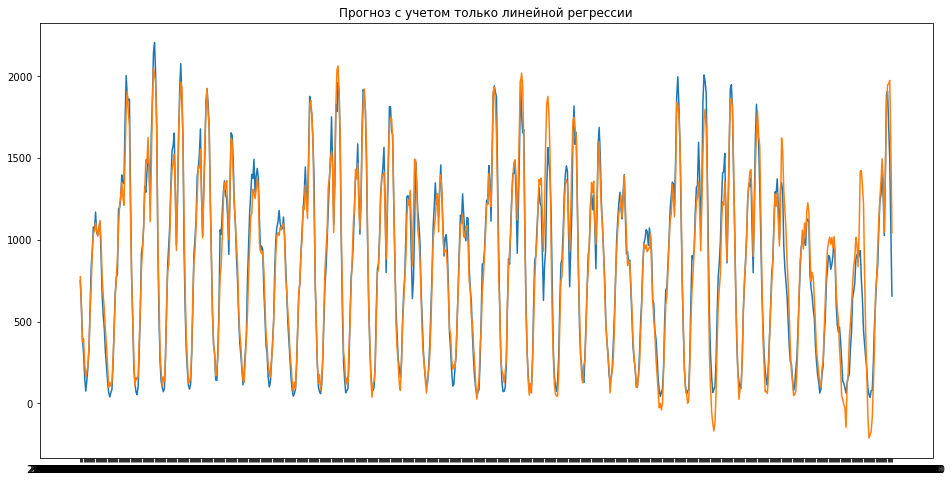

In [139]:
plt.figure(figsize=(16, 8))
plt.plot(current_data[current_region])
plt.plot(y_pred[-current_data.shape[0]:])
plt.title('Прогноз с учетом только линейной регрессии')
plt.show()

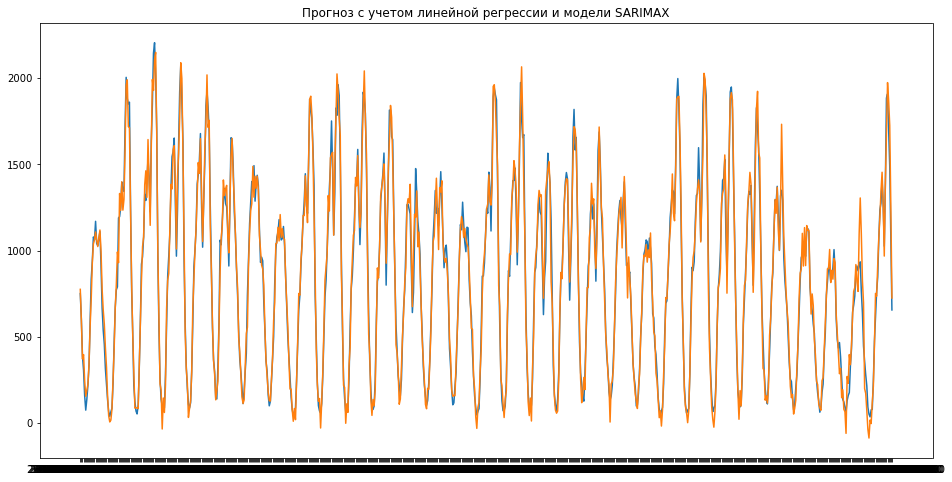

In [140]:
plt.figure(figsize=(16, 8))
plt.plot(current_data[current_region])
plt.plot(current_data['full_pred'])
plt.title('Прогноз с учетом линейной регрессии и модели SARIMAX')
plt.show()

6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

Результат только линейной регрессии

In [141]:
mean_squared_error(current_data[current_region], y_pred[-current_data.shape[0]:])

14996.902068547168

Результат линейной регрессии и SARIMAX

In [142]:
mean_squared_error(current_data[current_region], current_data['full_pred'])

7530.565096257829

Хотя по даже по первому графику, который показывает предсказания линейной регрессии, можно сказать, что результат уже достаточно серьезный, но с добавлением SARIMAX ошибка стала в два раза меньше и прогноз лучше сходится с реальными данными

И хотя мы прошли на пятом курсе прогноз временных рядов через линейную регрессию, но я почему-то проигнорировал эти знания и для меня было шоком, что 

7. Загрузите ноутбук в форму.